$$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ 20165549\ \ JANG\ \ JAE\ \ YONG$$

For a given input image (either gray or color), apply a K-means algorithm that is designed to take into consideration of both the image intensity and its spatial domain with varying parameters: the number of clusters and the trade-off between the intensity energy and the spatial energy.

(720, 480)


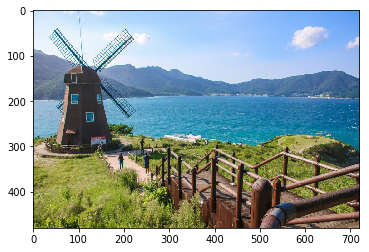

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

im = Image.open("testim2.jpg")  # 720 * 480 image
im_array = np.array(im)

size_row	= im.size[1]    # height of the image
size_col  	= im.size[0]    # width of the image

size_image	= size_row * size_col

#
# Distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    r = np.sqrt(s)
    
    return(r)

#
# make a matrix of result image
#
result_image = im_array.copy()

print(im.size)
plt.imshow(im_array)

$$[Selected\ \ image]$$

In [3]:
#
# normalize the values of the input data to be [0, 1]
#

im_val_array = np.empty((size_row, size_col , 5), dtype=float) # [x, y, r, g, b]
min_val = np.empty(3, dtype=float)
max_val = np.zeros(3, dtype=float)

for i in range(3):
    min_val[i] = 255

for k in range(3):
    for i in range(size_row):
        for j in range(size_col):
            if im_array[i, j, k] < min_val[k]:
                min_val[k] = im_array[i, j, k]
            if im_array[i, j, k] > max_val[k]:
                max_val[k] = im_array[i, j, k]

for i in range(size_row):
    for j in range(size_col):
        im_val_array[i, j, 0] = i / size_row
        im_val_array[i, j, 1] = j / size_col
        for k in range(3):
            diff = max_val[k] - min_val[k]
            im_val_array[i, j, k+2] = (im_array[i, j, k] - min_val[k]) / diff

The objective function is given by:

$\sum_k \sum_x \{ x \in I(k) \} [ \| f(x) - m_k \|^2 + \lambda * \| x - c_k \|^2 ]$

where $I(k)$ denotes the index set of $x$ that belongs to cluster $k, m_k$ denotes the centroid of image intensity for cluster $k, c_k$ denotes the centroid of spatial location for cluster $k$, and $\lambda$ determines the importance between the image intensity and the spatial relation.

**[K-means Algorithm]**

In [4]:
def K_Means_Algorithm(k, lambda_):
    
    # Get random label
    rand_label = np.random.randint(0, k, size_image)
    list_label = np.empty((size_row, size_col), dtype=int)
    
    for i in range(size_row):
        for j in range(size_col):
            list_label[i, j] = rand_label[(i+1)*j]
    
            
    # make a matrix of centroid
    # (RGB, K) 
    rgb_centroid = np.zeros((3, k), dtype=float) 
    # (XY, K)
    domain_centroid = np.zeros((2, k), dtype=float) 
    
    # make a matrix of iteration
    d_iteration = np.zeros((2, k), dtype=float)
    v_iteration = np.zeros((3, k), dtype=float)
    d_count = np.zeros((2, k), dtype=float)
    v_count = np.zeros((3, k), dtype=float)
    
    #
    # Initial label
    #
    for i in range(size_row):
        for j in range(size_col):
            for t in range(2):
                domain_centroid[:, list_label[i, j]] += im_val_array[i, j, t]
            for t in range(3):
                rgb_centroid[t, list_label[i, j]] += im_val_array[i, j, t+2]
            d_count[: ,list_label[i, j]] += 1
            v_count[: ,list_label[i, j]] += 1
    domain_centroid /= d_count
    rgb_centroid /= v_count
    d_count *= 0
    v_count *= 0
    
    list_distance = np.empty(k, dtype=float)
    dist_sum = np.zeros(k, dtype=float)
    energy_list = np.zeros(11 , dtype=float)
    
    
    loc1 = np.zeros(2 , dtype=float)
    loc2 = np.zeros(2 , dtype=float)
    
    val1 = np.zeros(3 , dtype=float)
    val2 = np.zeros(3 , dtype=float)
    
    #
    # Iterating 6 times.
    #
    for iterate in range(6):
        
        for i in range(size_row):
            for j in range(size_col):
                for l in range(2):
                    loc1[l] = im_val_array[i, j, l]
                for v in range(3):
                    val1[v] = im_val_array[i, j, v+2]
                for t in range(k):
                    loc2[:] = domain_centroid[:, t]
                    val2[:] = rgb_centroid[:, t]
                    list_distance[t] = distance(val1, val2) + (lambda_ * distance(loc1, loc2))
                
                min_value = min(list_distance)
                distance_index = np.where(list_distance == min_value)
                
                for l in range(2):
                    d_iteration[l, int(distance_index[0])] += im_val_array[i, j, l]
                for v in range(3):
                    v_iteration[v, int(distance_index[0])] += im_val_array[i, j, v+2]
                
                d_count[:, int(distance_index[0])] += 1            
                v_count[:, int(distance_index[0])] += 1    
                
                dist_sum[int(distance_index[0])] += min_value
                list_label[i, j] = int(distance_index[0])
            
        #
        # compute Centroid
        #
        domain_centroid = d_iteration.copy()
        domain_centroid = domain_centroid / d_count
        rgb_centroid = v_iteration.copy()
        rgb_centroid = rgb_centroid / v_count
        
        #
        # compute Energy
        #
        energy_sum = dist_sum.sum()
        energy_sum /= size_image
        energy_list[iterate] = energy_sum
        
        #
        # end loop
        #
        if energy_sum == energy_list[iterate - 1]:
            break
        
        #
        # initialize
        #
        dist_sum *= 0
        energy_sum = 0
        
        d_iteration *= 0
        v_iteration *= 0
        d_count *= 0
        v_count *= 0
       
    #
    # Plot input image in color.
    #
    for i in range(size_row):
        for j in range(size_col):
            C = rgb_centroid[:, list_label[i, j]]
            result_image[i, j, :] = (C * (max_val[:] - min_val[:])) + min_val[:]
    
    plt.imshow(result_image)
    
    return np.array(energy_list)
    # Return Energy

**[Energy]**

- Visualize the energy curve for both the intensity energy and the spatial energy.

In [5]:
def Energy():
    
    x = range(6)       # Iterating 6 times.
    y = E[x]            # Energy per optimization iteration.
    plt.plot(x, y, "RED")
    plt.title('Energy')
    plt.xlabel('Iterations')
    plt.ylabel('Energy')
    
    plt.show()

**[Visualisation]**

- Visualize the clustering results with varying $k$ and a using the centroid color $m_k$ for each cluster $k$.

# . Results of running the K-means with $K = 2$

## . $\lambda = 0.5$

Output image for $K = 2$ , $\lambda = 0.5$

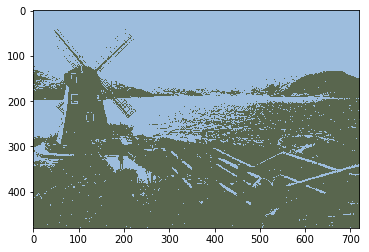

In [109]:
k = 2
lambda_ = 0.5
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 2$, $\lambda = 0.5$

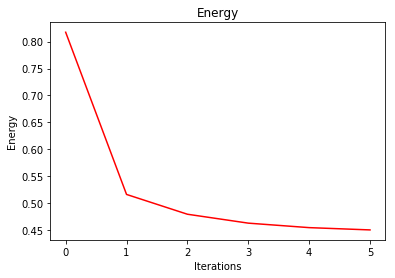

In [110]:
Energy()

## . $\lambda = 2$

Output image for $K = 2$ , $\lambda = 2$

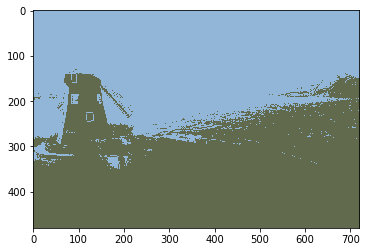

In [113]:
k = 2
lambda_ = 2
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 2$, $\lambda = 10$

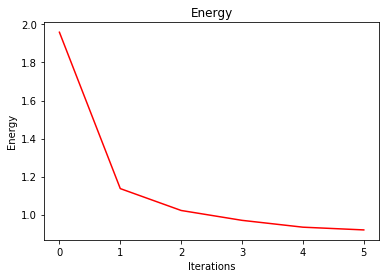

In [114]:
Energy()

# . Results of running the K-means with $K = 3$

## . $\lambda = 0.5$

Output image for $K = 3$ , $\lambda = 0.5$

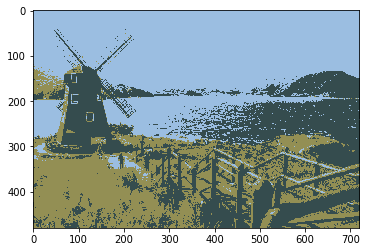

In [181]:
k = 3
lambda_ = 0.5
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 3$, $\lambda = 0.5$

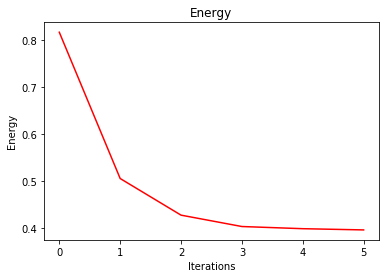

In [182]:
Energy()

## . $\lambda = 0.7$

Output image for $K = 3$ , $\lambda = 0.7$

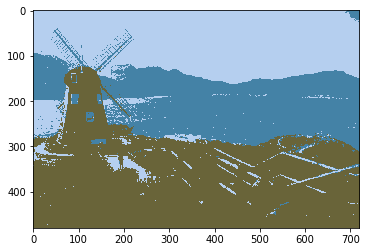

In [34]:
k = 3
lambda_ = 0.7
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 3$, $\lambda = 0.7$

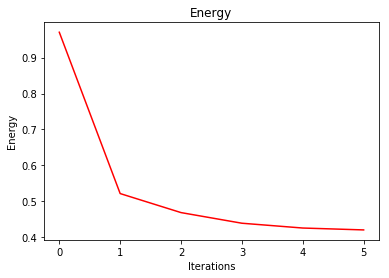

In [35]:
Energy()

# . Results of running the K-means with $K = 4$

## . $\lambda = 0.5$

Output image for $K = 4$ , $\lambda = 0.5$

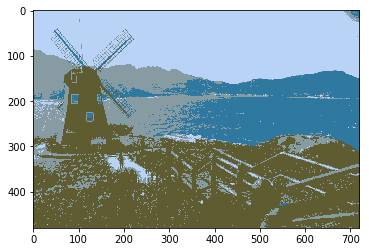

In [50]:
k = 4
lambda_ = 0.5
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 4$, $\lambda = 0.5$

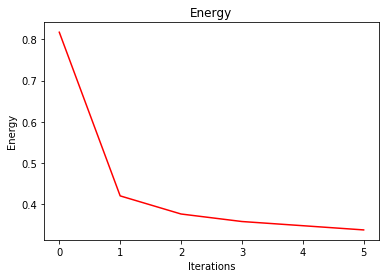

In [51]:
Energy()

## . $\lambda = 0.7$

Output image for $K = 4$ , $\lambda = 0.7$

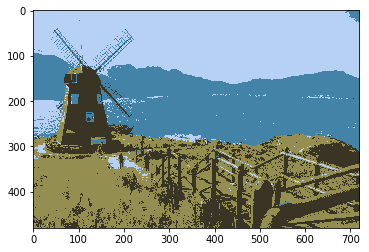

In [14]:
k = 4
lambda_ = 0.7
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 4$, $\lambda = 0.7$

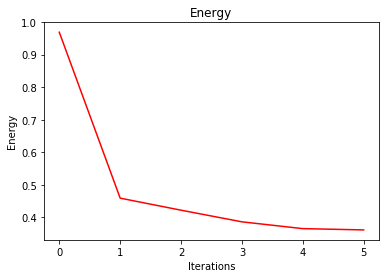

In [15]:
Energy()

# . Results of running the K-means with $K = 5$

## . $\lambda = 0.5$

Output image for $K = 5$ , $\lambda = 0.5$

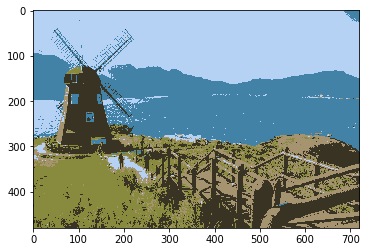

In [79]:
k = 5
lambda_ = 0.5
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 5$, $\lambda = 0.5$

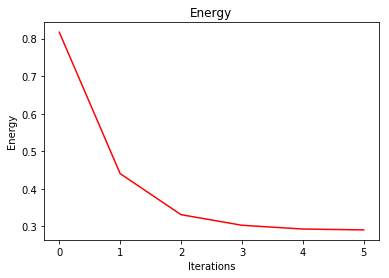

In [80]:
Energy()

## . $\lambda = 0.7$

Output image for $K = 5$ , $\lambda = 0.7$

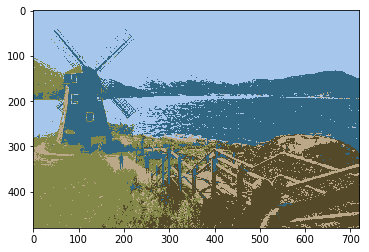

In [19]:
k = 5
lambda_ = 0.7
E = K_Means_Algorithm(k, lambda_)

Plot the energy curve for $K = 5$, $\lambda = 0.7$

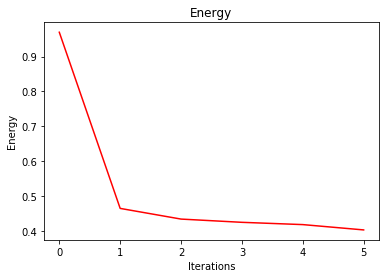

In [20]:
Energy()